In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd


import lalsimulation.gwsignal.core.waveform as wfm
import astropy.units as u
from gwpy.frequencyseries import FrequencySeries

from gw_signal_tools.waveform_utils import get_wf_generator
from gw_signal_tools.fisher import (
    get_waveform_derivative_1D, get_waveform_derivative_1D_with_convergence,
    fisher_matrix, FisherMatrix
)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

In [3]:
f_min = 20.*u.Hz
f_max = 1024.*u.Hz

wf_params = {
    # 'total_mass': 100.*u.solMass,
    # 'total_mass': 50.*u.solMass,
    # 'chirp_mass': 50.*u.solMass,
    'chirp_mass': 30.*u.solMass,
    'mass_ratio': 0.42*u.dimensionless_unscaled,
    'deltaT': 1./2048.*u.s,
    'f22_start': f_min,
    # 'deltaF': 2**-10*u.Hz,
    'deltaF': 2**-8*u.Hz,
    'f_max': f_max,
    'f22_ref': 20.*u.Hz,
    'phi_ref': 0.*u.rad,
    # 'distance': 1.*u.Mpc,
    'distance': 440.*u.Mpc,
    'inclination': 0.0*u.rad,
    'eccentricity': 0.*u.dimensionless_unscaled,
    'longAscNodes': 0.*u.rad,
    'meanPerAno': 0.*u.rad,
    # 'spin1z': 0.42*u.dimensionless_unscaled,
    'condition': 0
}

# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
wf_generator = get_wf_generator(approximant)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


# Derivative Testing

In [4]:
# param_to_vary = 'total_mass'
param_to_vary = 'chirp_mass'
# param_to_vary = 'sym_mass_ratio'
# param_to_vary = 'mass_ratio'
# param_to_vary = 'distance'
# param_to_vary = 'spin1z'

* total_mass: very good agreement, 1e-6 relative difference for lower frequencies and not more than 1e-3 overall -> gets worse, 1e-2 for larger frequencies; is perhaps due to large influence of total mass on phase; this is what it looks like for 100 Msun, for 50 Msun things are one to two orders of magnitude below these numbers
* chirp_mass: agreement is good, relative error of around 1e-3 until values get close to zero
* sym_mass_ratio: not perfect for 0.05, but this is very challenging territory
* mass_ratio: pretty good, relative differences are never larger than 1e-4 until $\approx 60 Hz$; larger for higher frequencies, but numdifftools error increases there drastically as well, which means this might not come from our implementation
* distance: really good for mass ratio 0.42 (1e-9 relative error), but for 0.5 it is not good, phases seem to differ quite a bit

In [5]:
num_deriv, info_dict = get_waveform_derivative_1D_with_convergence(
    wf_params,
    param_to_vary,
    wf_generator,
    convergence_check='diff_norm',
    # convergence_threshold=0.005,
    # convergence_threshold=0.0001,  # Testing if relative difference becomes smaller when doing this -> yes it does; but computation time also increases significantly
    # start_step_size=1e-3,
    # start_step_size=1e-8,  # For fun
    return_info=True
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

{'norm_squared': <Quantity 9.13607631e-43 1 / solMass2>, 'final_step_size': 0.0005, 'final_convergence_val': <Quantity 0.00018878>, 'number_of_refinements': 0, 'final_set_of_step_sizes': array([1.e-02, 5.e-03, 1.e-03, 5.e-04, 1.e-04, 5.e-05, 1.e-05,
       5.e-06, 1.e-06]), 'convergence_plot': array([<Axes: ylabel='Derivative Re'>,
       <Axes: xlabel='$f$', ylabel='Derivative Im'>],
      dtype=object)}


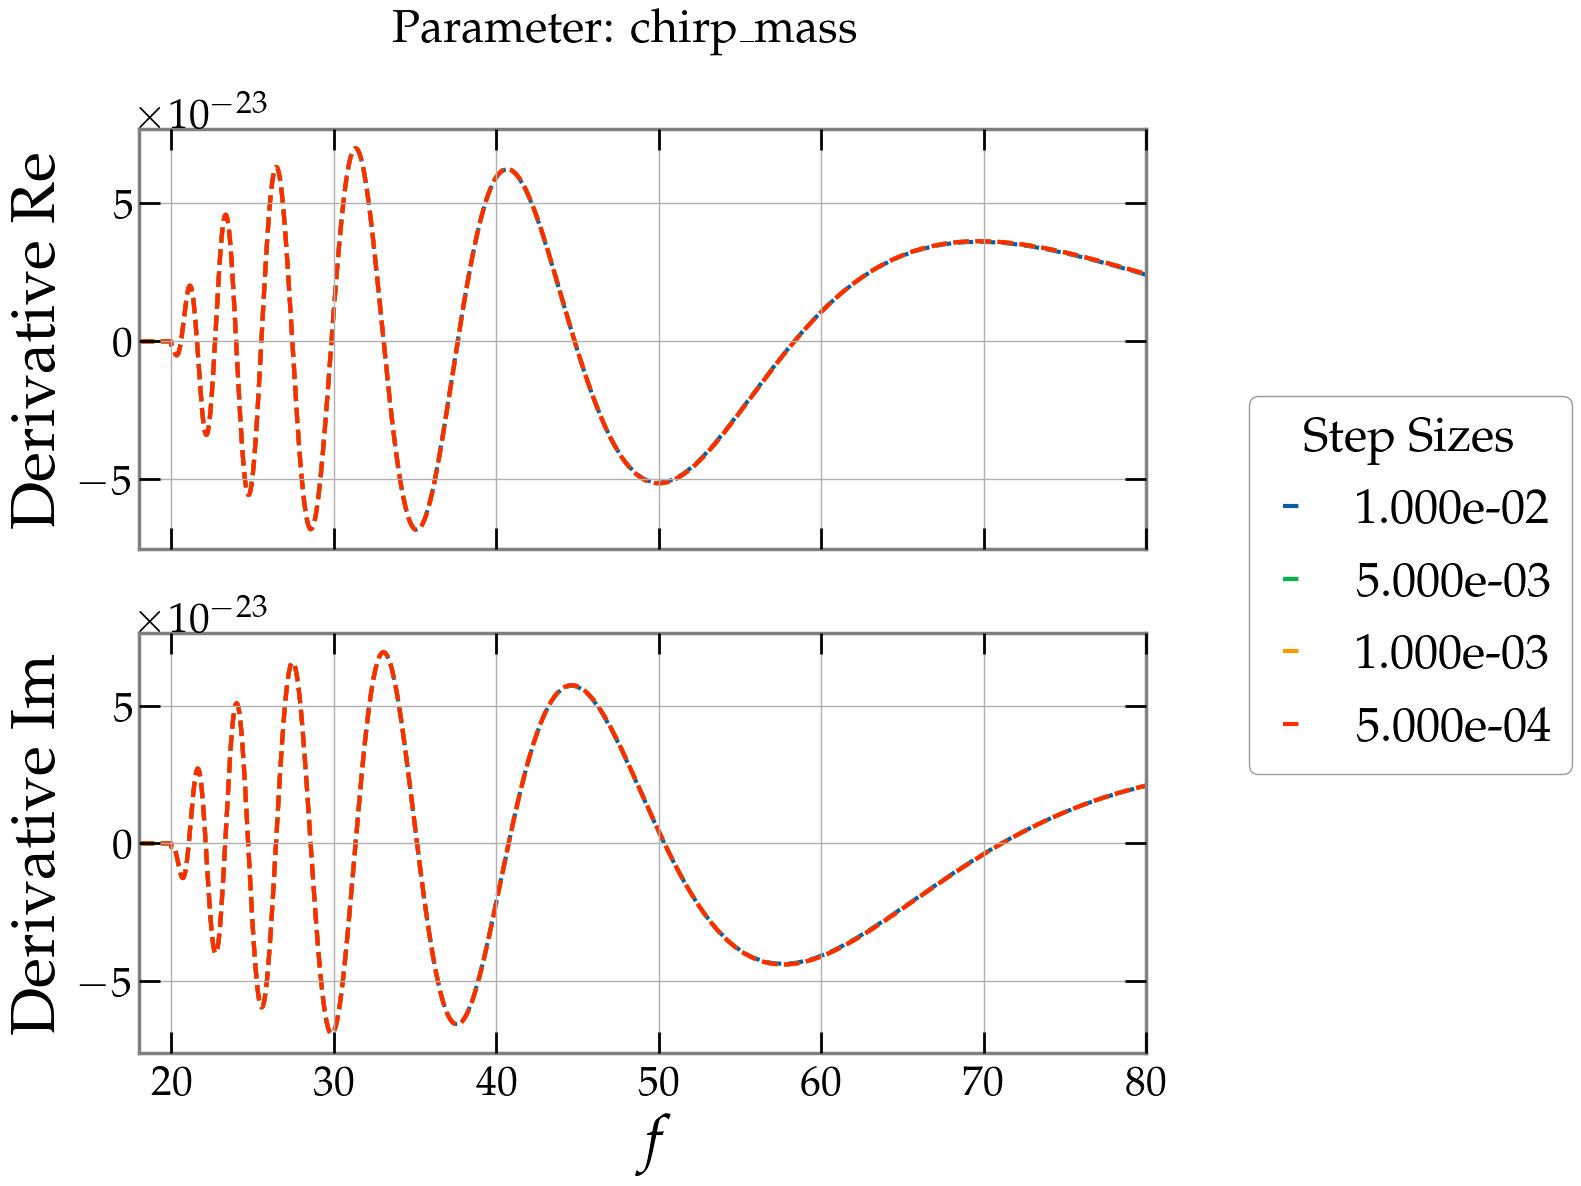

In [6]:
print(info_dict)

ax = info_dict['convergence_plot']

plt.xlim([18, 80])

plt.show()

Convergence/stability is demonstrated here very well

In [7]:
def deriv_wrapper_real(param_val):
    return wf_generator(wf_params | {param_to_vary: param_val * wf_params[param_to_vary].unit}).real

def deriv_wrapper_imag(param_val):
    return wf_generator(wf_params | {param_to_vary: param_val * wf_params[param_to_vary].unit}).imag


center_val = wf_params[param_to_vary]


# max_step_size = None
max_step_size = 1e-2 * center_val.value  # Seems to cause issue sometimes, maybe use value of this?

nd_deriv_real = nd.Derivative(deriv_wrapper_real, full_output=True, base_step=max_step_size)

nd_deriv_imag = nd.Derivative(deriv_wrapper_imag, full_output=True, base_step=max_step_size)
# For more step size handling, see https://numdifftools.readthedocs.io/en/latest/reference/numdifftools.html#numdifftools.step_generators.BasicMaxStepGenerator

nd_deriv = FrequencySeries(
    nd_deriv_real(center_val)[0] + 1.j * nd_deriv_imag(center_val)[0],
    frequencies=num_deriv.frequencies,
    unit=num_deriv.unit
)

nd_deriv_error_est = FrequencySeries(
    nd_deriv_real(center_val)[1].error_estimate + 1.j * nd_deriv_imag(center_val)[1].error_estimate,
    frequencies=num_deriv.frequencies,
    unit=num_deriv.unit
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

Problem: fairly frequently, bounds of allowed parameter ranges are reached

In [8]:
# gwbench does things differently for complex numbers

def gwbench_deriv_wrapper_abs(param_val):
    return np.abs(wf_generator(wf_params | {param_to_vary: param_val * wf_params[param_to_vary].unit}).value)

def gwbench_deriv_wrapper_phase(param_val):
    return np.unwrap(np.angle(wf_generator(wf_params | {param_to_vary: param_val * wf_params[param_to_vary].unit}).value))


center_val = wf_params[param_to_vary]


# max_step_size = None
max_step_size = 1e-2 * center_val.value

nd_deriv_abs = nd.Derivative(gwbench_deriv_wrapper_abs, base_step=max_step_size)

nd_deriv_phase = nd.Derivative(gwbench_deriv_wrapper_phase, base_step=max_step_size)

amp = np.abs(wf_generator(wf_params)).value
pha = np.unwrap(np.angle(wf_generator(wf_params))).value

gwbench_nd_deriv = FrequencySeries(
    # nd_deriv_abs(center_val)[0] * np.exp(1j*pha) + amp * np.exp(1j*pha) * 1j * nd_deriv_phase(center_val)[0],  # In case full_output=True
    nd_deriv_abs(center_val) * np.exp(1j*pha) + amp * np.exp(1j*pha) * 1j * nd_deriv_phase(center_val),
    frequencies=num_deriv.frequencies,
    unit=num_deriv.unit
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


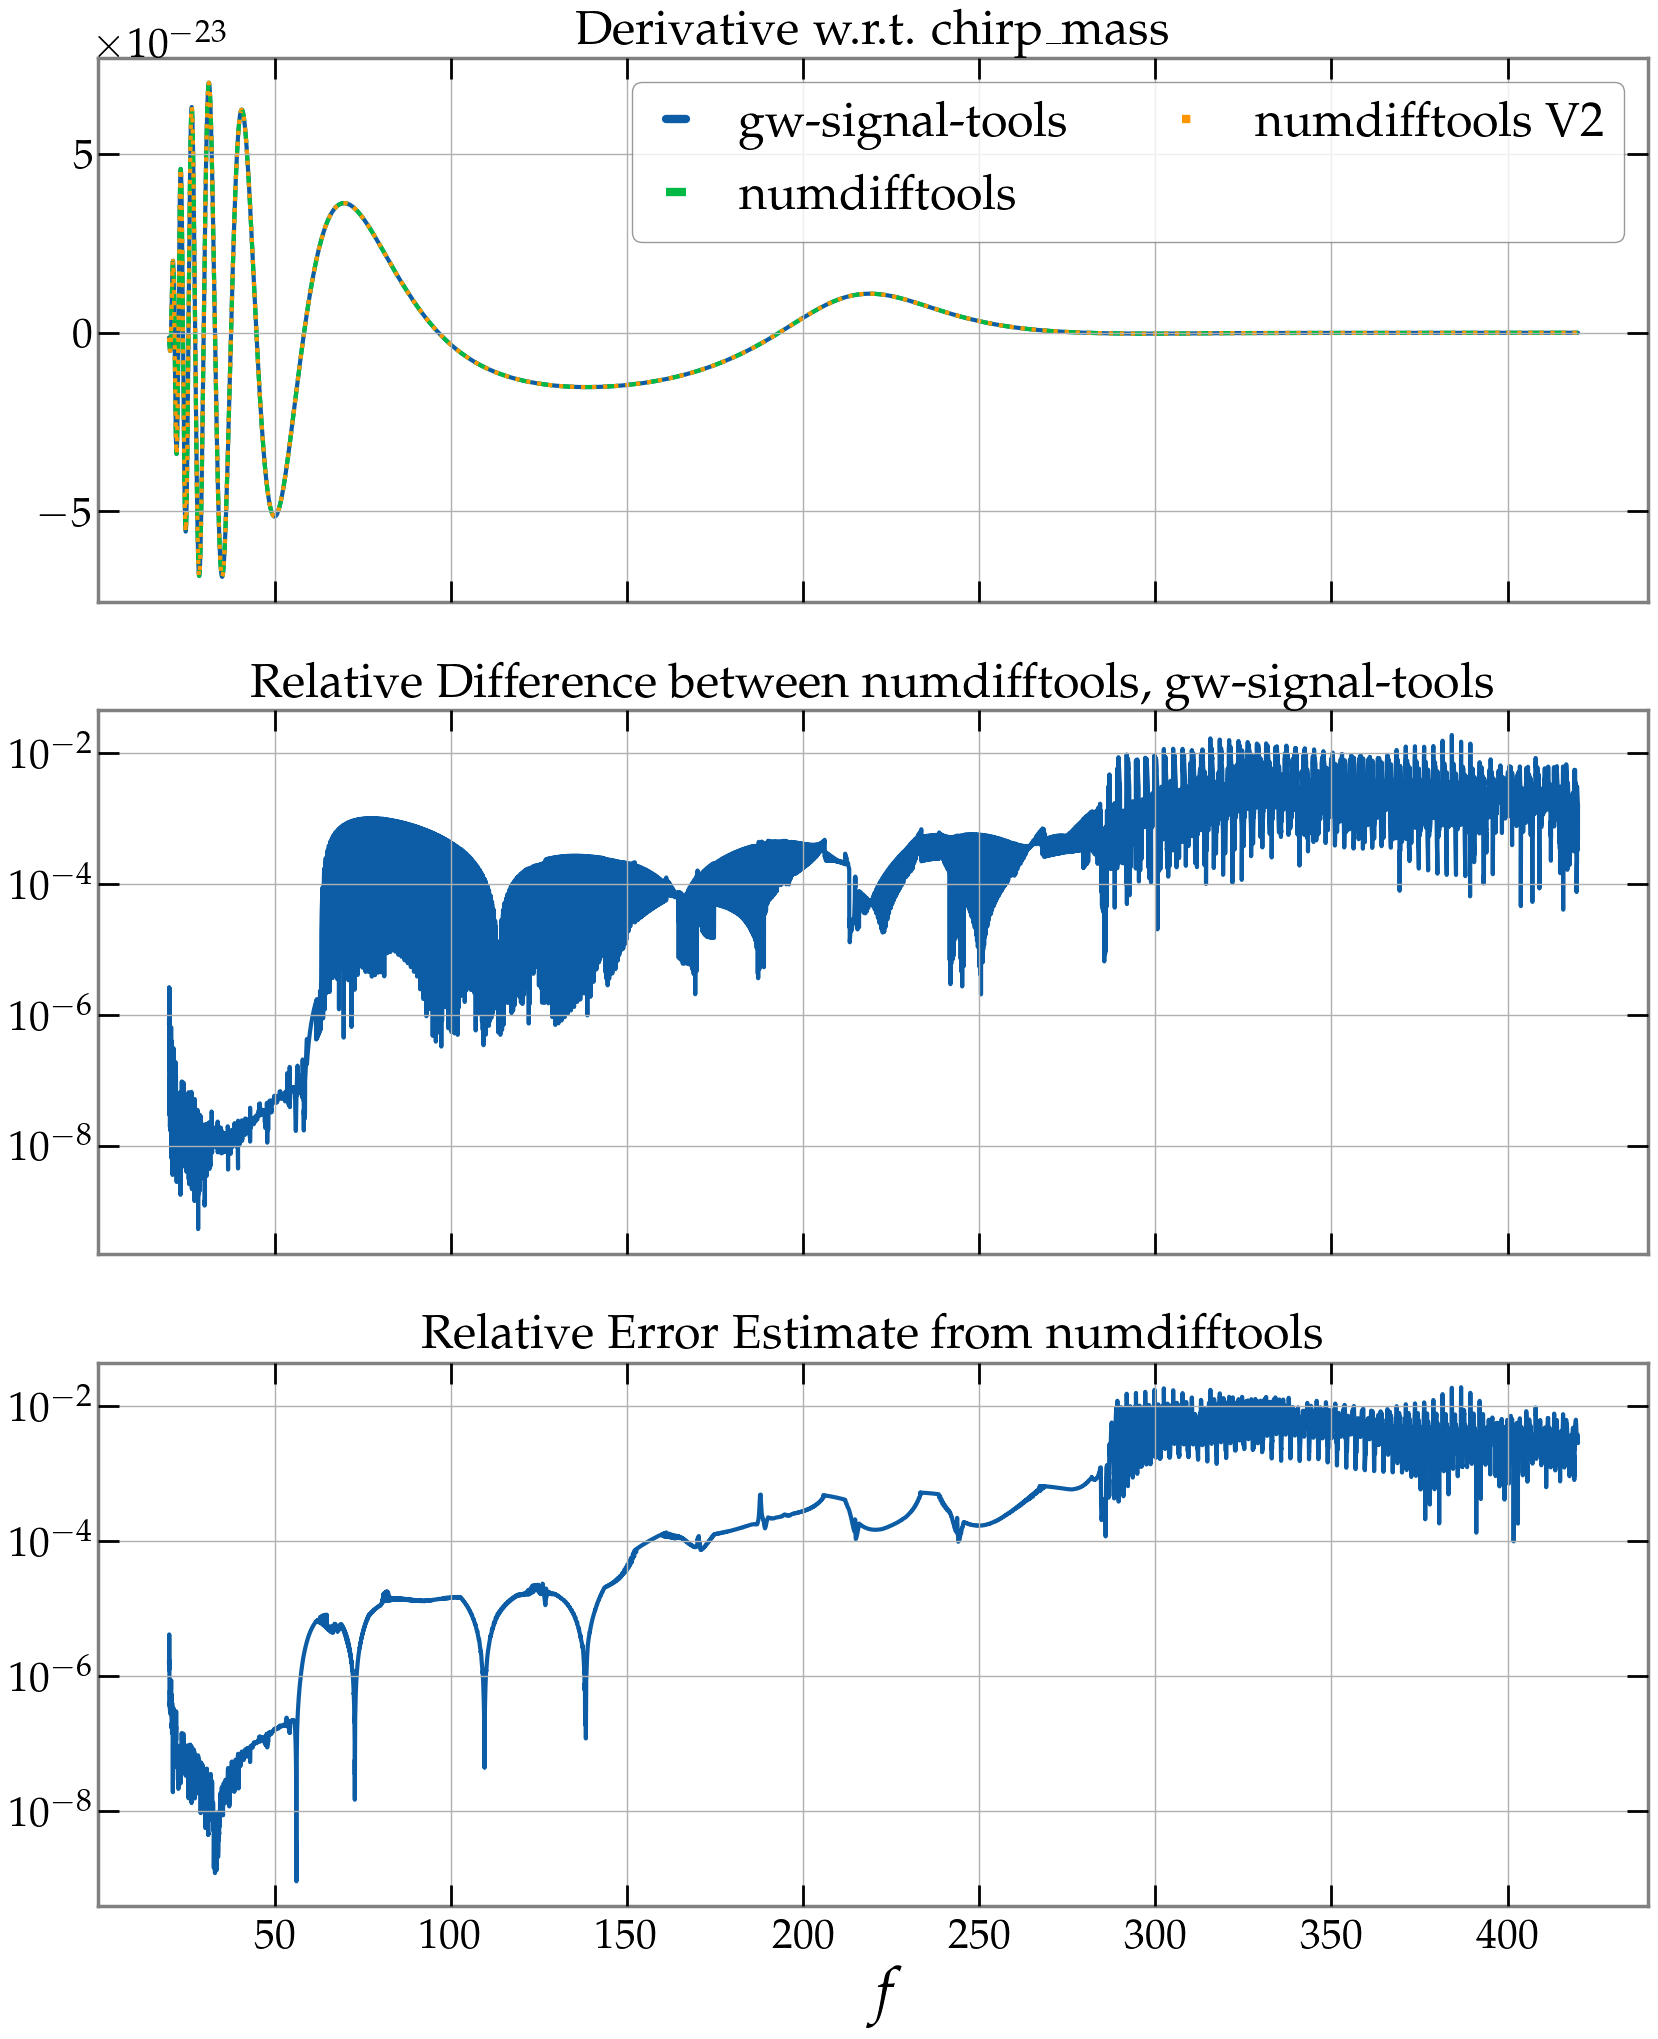

In [9]:
# f_range=[f_min, f_max]
# f_range=[f_min, 60. * u.Hz]
# f_range=[f_min, 200. * u.Hz]
f_range=[f_min, 420. * u.Hz]


fig, ax = plt.subplots(figsize=(20,24), nrows=3, sharex=True)

ax[0,].plot(num_deriv.crop(start=f_range[0], end=f_range[1]), label='gw-signal-tools')
ax[0,].plot(nd_deriv.crop(start=f_range[0], end=f_range[1]), '--', label='numdifftools')
ax[0,].plot(gwbench_nd_deriv.crop(start=f_range[0], end=f_range[1]), ':', label='numdifftools V2')


ax[1,].plot(((num_deriv - nd_deriv) / num_deriv).abs().crop(start=f_range[0], end=f_range[1]))
# ax[1,].plot(((num_deriv - gwbench_nd_deriv) / num_deriv).abs().crop(start=f_range[0], end=f_range[1]), ':')  # Plot too full with it


ax[2,].plot((nd_deriv_error_est / nd_deriv).abs().crop(start=f_range[0], end=f_range[1]))


ax[1,].set_yscale('log')
ax[2,].set_yscale('log')
ax[0,].set_title(f'Derivative w.r.t. {param_to_vary}')
plt.xlabel('$f$')
ax[0,].legend(ncols=2)
ax[1,].set_title('Relative Difference between numdifftools, gw-signal-tools')
ax[2,].set_title('Relative Error Estimate from numdifftools')

plt.show()

Relative difference on scale of error estimate is good, right? Should mean we get equal to numdifftools result that we are on scale of its error, i.e. the deviation need not come from our own implementation

In [10]:
from gw_signal_tools.inner_product import norm

In [11]:
f_range = None  # No restriction here

fisher1 = norm(num_deriv, f_range=f_range)
fisher2 = norm(nd_deriv, f_range=f_range)

In [12]:
print(fisher1, fisher2, abs((fisher1 - fisher2) / fisher1))

9.55828243206657e-22 1 / solMass 9.558302766923158e-22 1 / solMass 2.127459272402858e-06


Agreement is good, only real deviations (around 1%) occur for extreme situations like very small symmetric mass ratio, otherwise usually around 1e-4 or even lower.

## Verification with Analytical Derivatives

### Phase and Time

In [13]:
waveform = wf_generator(wf_params)
ana_deriv_time = waveform * -1j * 2. * np.pi * waveform.frequencies
ana_deriv_phase = waveform * 2j

num_deriv_phase, info_dict_phase = get_waveform_derivative_1D_with_convergence(
    wf_params,
    'phi_ref',
    wf_generator,
    convergence_check='diff_norm',
    return_info=True,
)
plt.close()

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


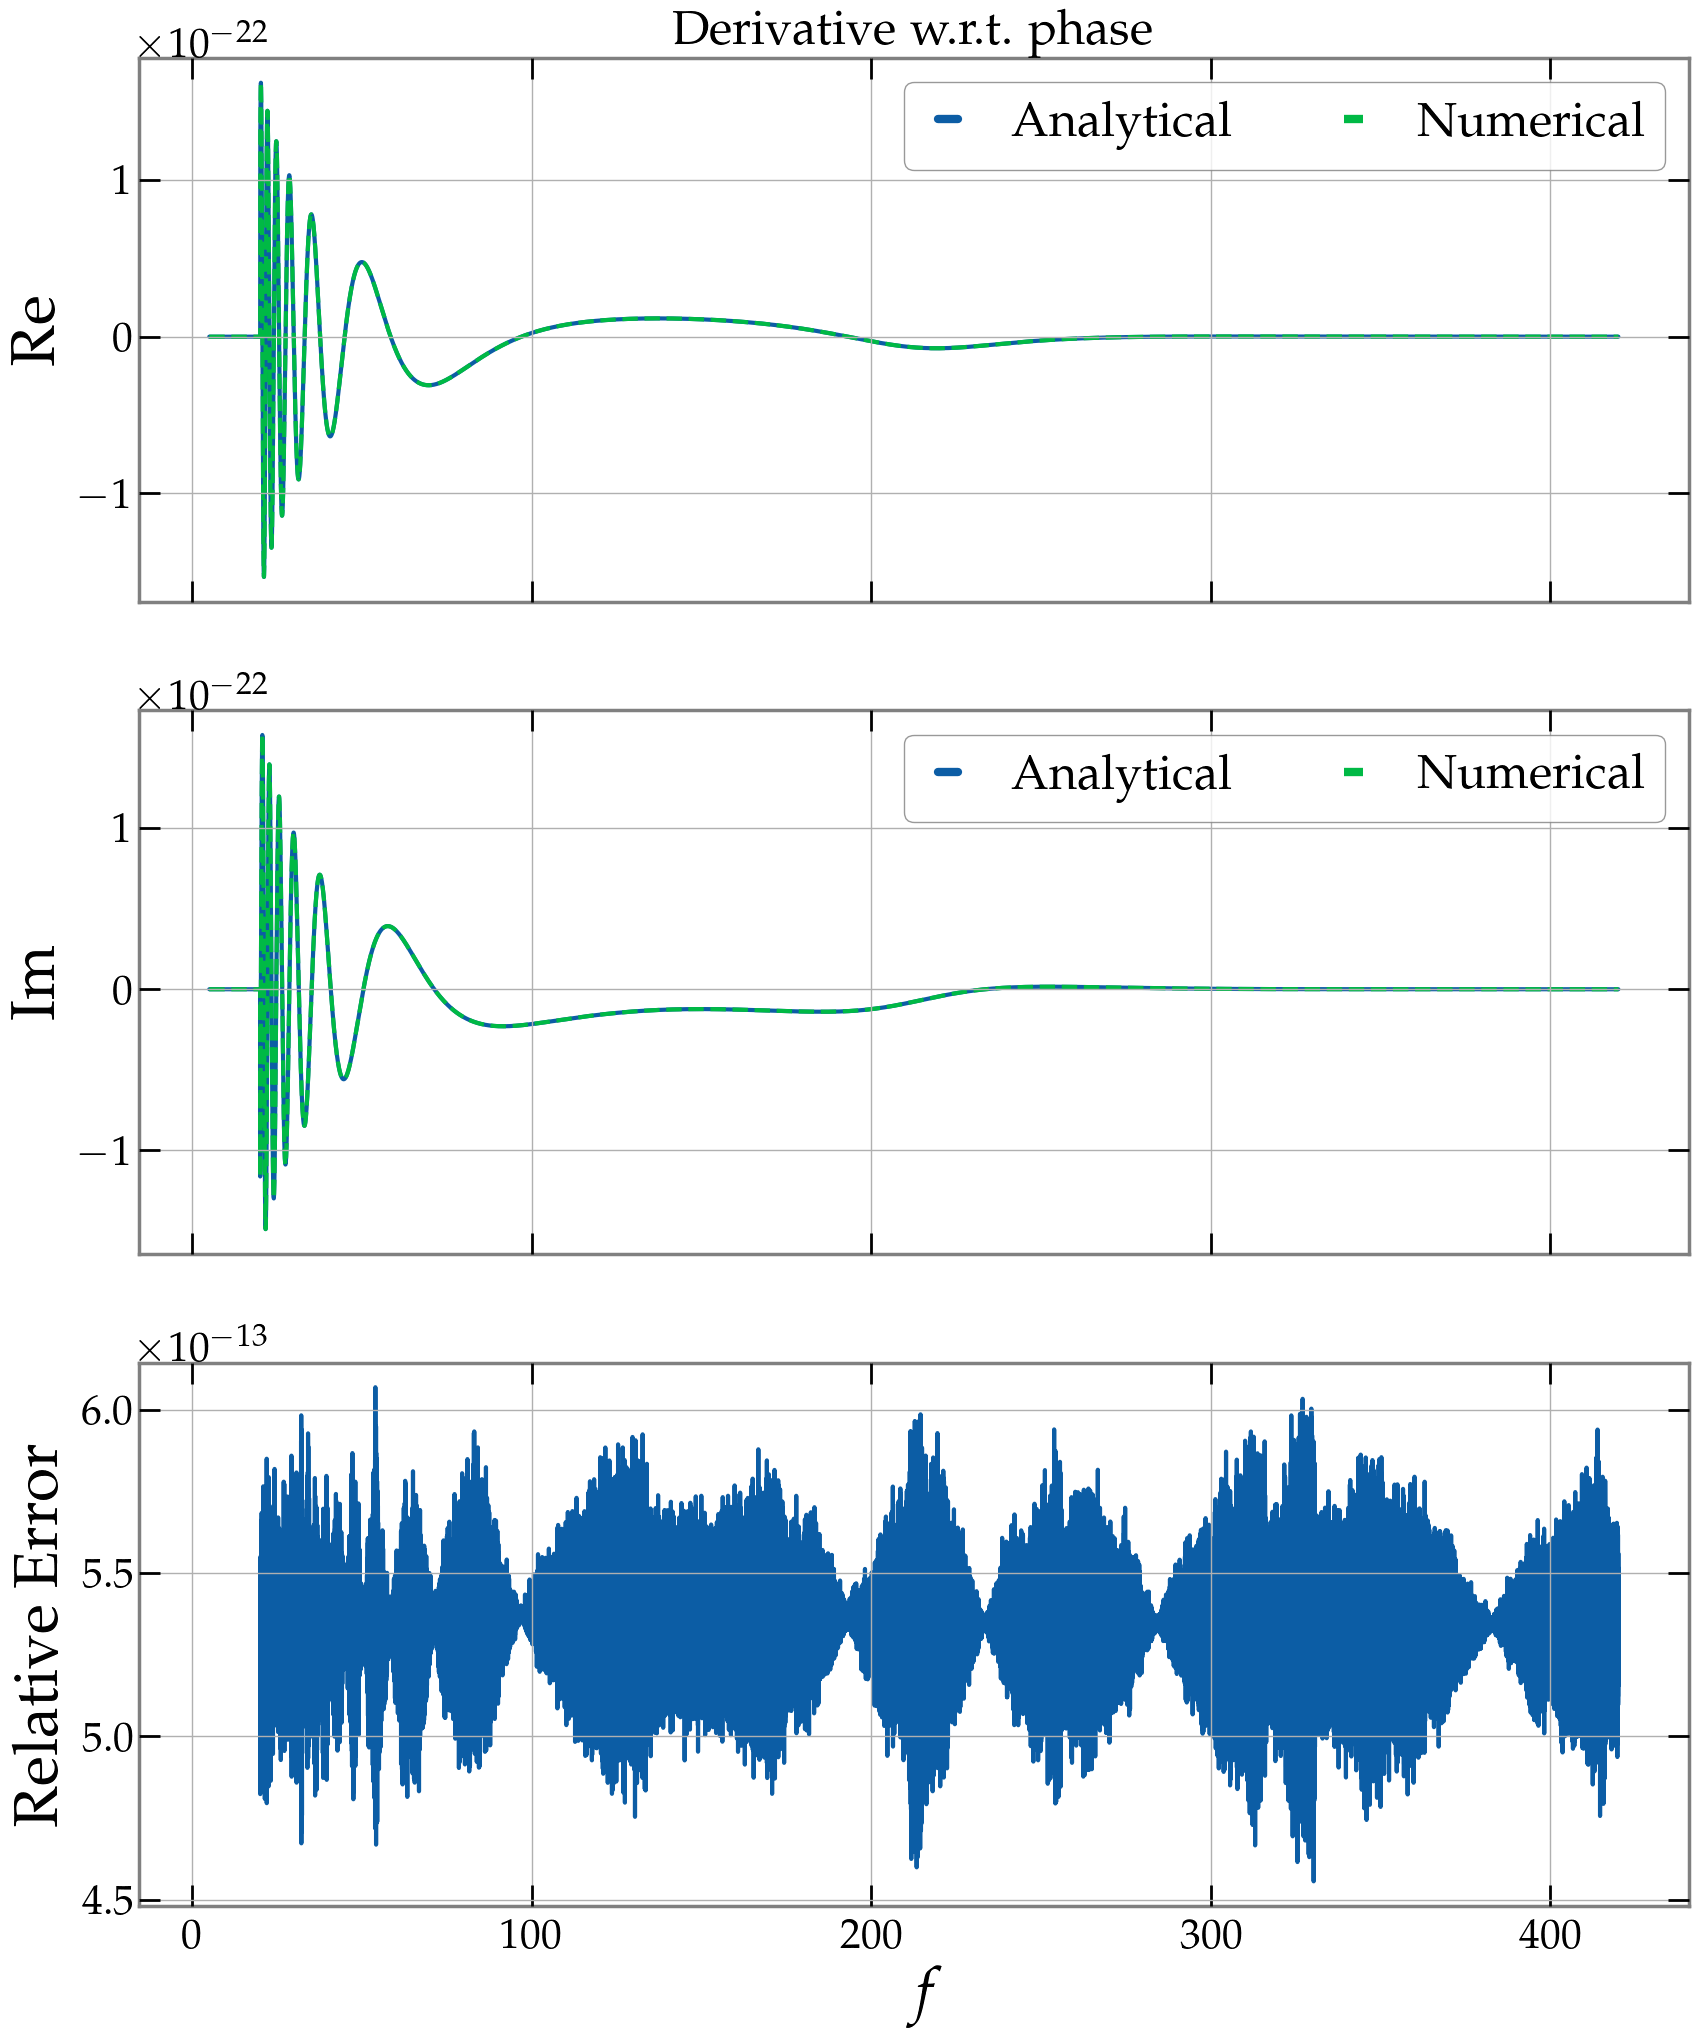

In [14]:
f_range=[5.*u.Hz, 420.*u.Hz]


fig, ax = plt.subplots(figsize=(20,24), nrows=3, sharex=True)

ax[0].plot(ana_deriv_phase.crop(start=f_range[0], end=f_range[1]).real, label='Analytical')
ax[0].plot(num_deriv_phase.crop(start=f_range[0], end=f_range[1]).real, '--', label='Numerical')


ax[1].plot(ana_deriv_phase.crop(start=f_range[0], end=f_range[1]).imag, label='Analytical')
ax[1].plot(num_deriv_phase.crop(start=f_range[0], end=f_range[1]).imag, '--', label='Numerical')


ax[2].plot(((ana_deriv_phase - num_deriv_phase) / ana_deriv_phase).abs().crop(start=f_range[0], end=f_range[1]))


ax[0].legend(ncols=2)
ax[1].legend(ncols=2)
ax[0].set_title('Derivative w.r.t. phase')
ax[0].set_ylabel('Re')
ax[1].set_ylabel('Im')
ax[2].set_ylabel('Relative Error')
plt.xlabel('$f$')
# plt.xlim(5, 100)

plt.show()

Very good agreement. Note, however, that this might not be the case if higher harmonics have a significant impact or if the binary is precessing.

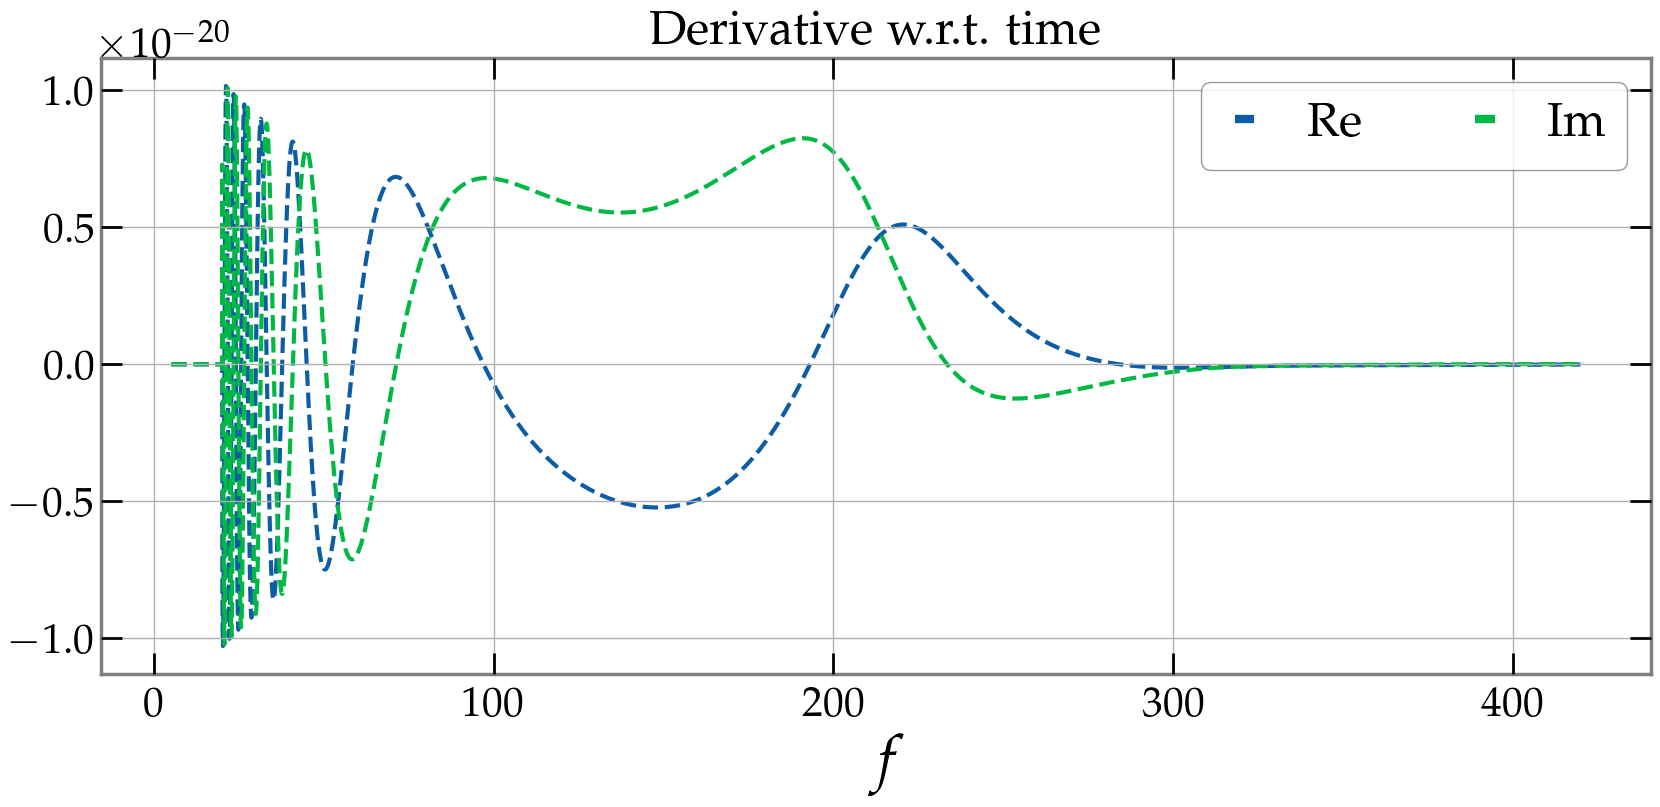

In [15]:
f_range=[5.*u.Hz, 420.*u.Hz]


fig, ax = plt.subplots(figsize=(20,8))

ax.plot(ana_deriv_time.crop(start=f_range[0], end=f_range[1]).real, '--', label='Re')
ax.plot(ana_deriv_time.crop(start=f_range[0], end=f_range[1]).imag, '--', label='Im')

ax.set_title('Derivative w.r.t. time')
ax.set_xlabel('$f$')
ax.legend(ncols=2)
# plt.xlim(5, 100)

plt.show()

### Luminosity Distance

For the distance, we can calculate a analytical derivative by noticing that

$$h(f, D_L) = h(f, 1) / D_L$$

which implies

$$\frac{\partial h(f, D_L)}{\partial D_L} = h(f, 1) \frac{\partial 1/D_L}{\partial D_L} = h(f, 1) (-1 / D_L^2) = - h(f, D_L) / D_L .$$

In [4]:
# We rename distance parameter in the new generator so that derivative
# routine does not recognize it and uses analytical derivative
def dist_deriv_gen(wf_params):
    _wf_params = wf_params.copy()
    _wf_params['distance'] = _wf_params.pop('dist')

    return wf_generator(_wf_params)

dist_deriv_params = wf_params.copy()
dist_deriv_params.pop('distance');
dist_deriv_params['dist'] = wf_params['distance']

num_deriv_distance, info_dict_distance = get_waveform_derivative_1D_with_convergence(
    dist_deriv_params,
    'dist',
    dist_deriv_gen,
    convergence_check='diff_norm',
    return_info=True,
)
plt.close()

ana_deriv_distance = - wf_generator(wf_params) / wf_params['distance']

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


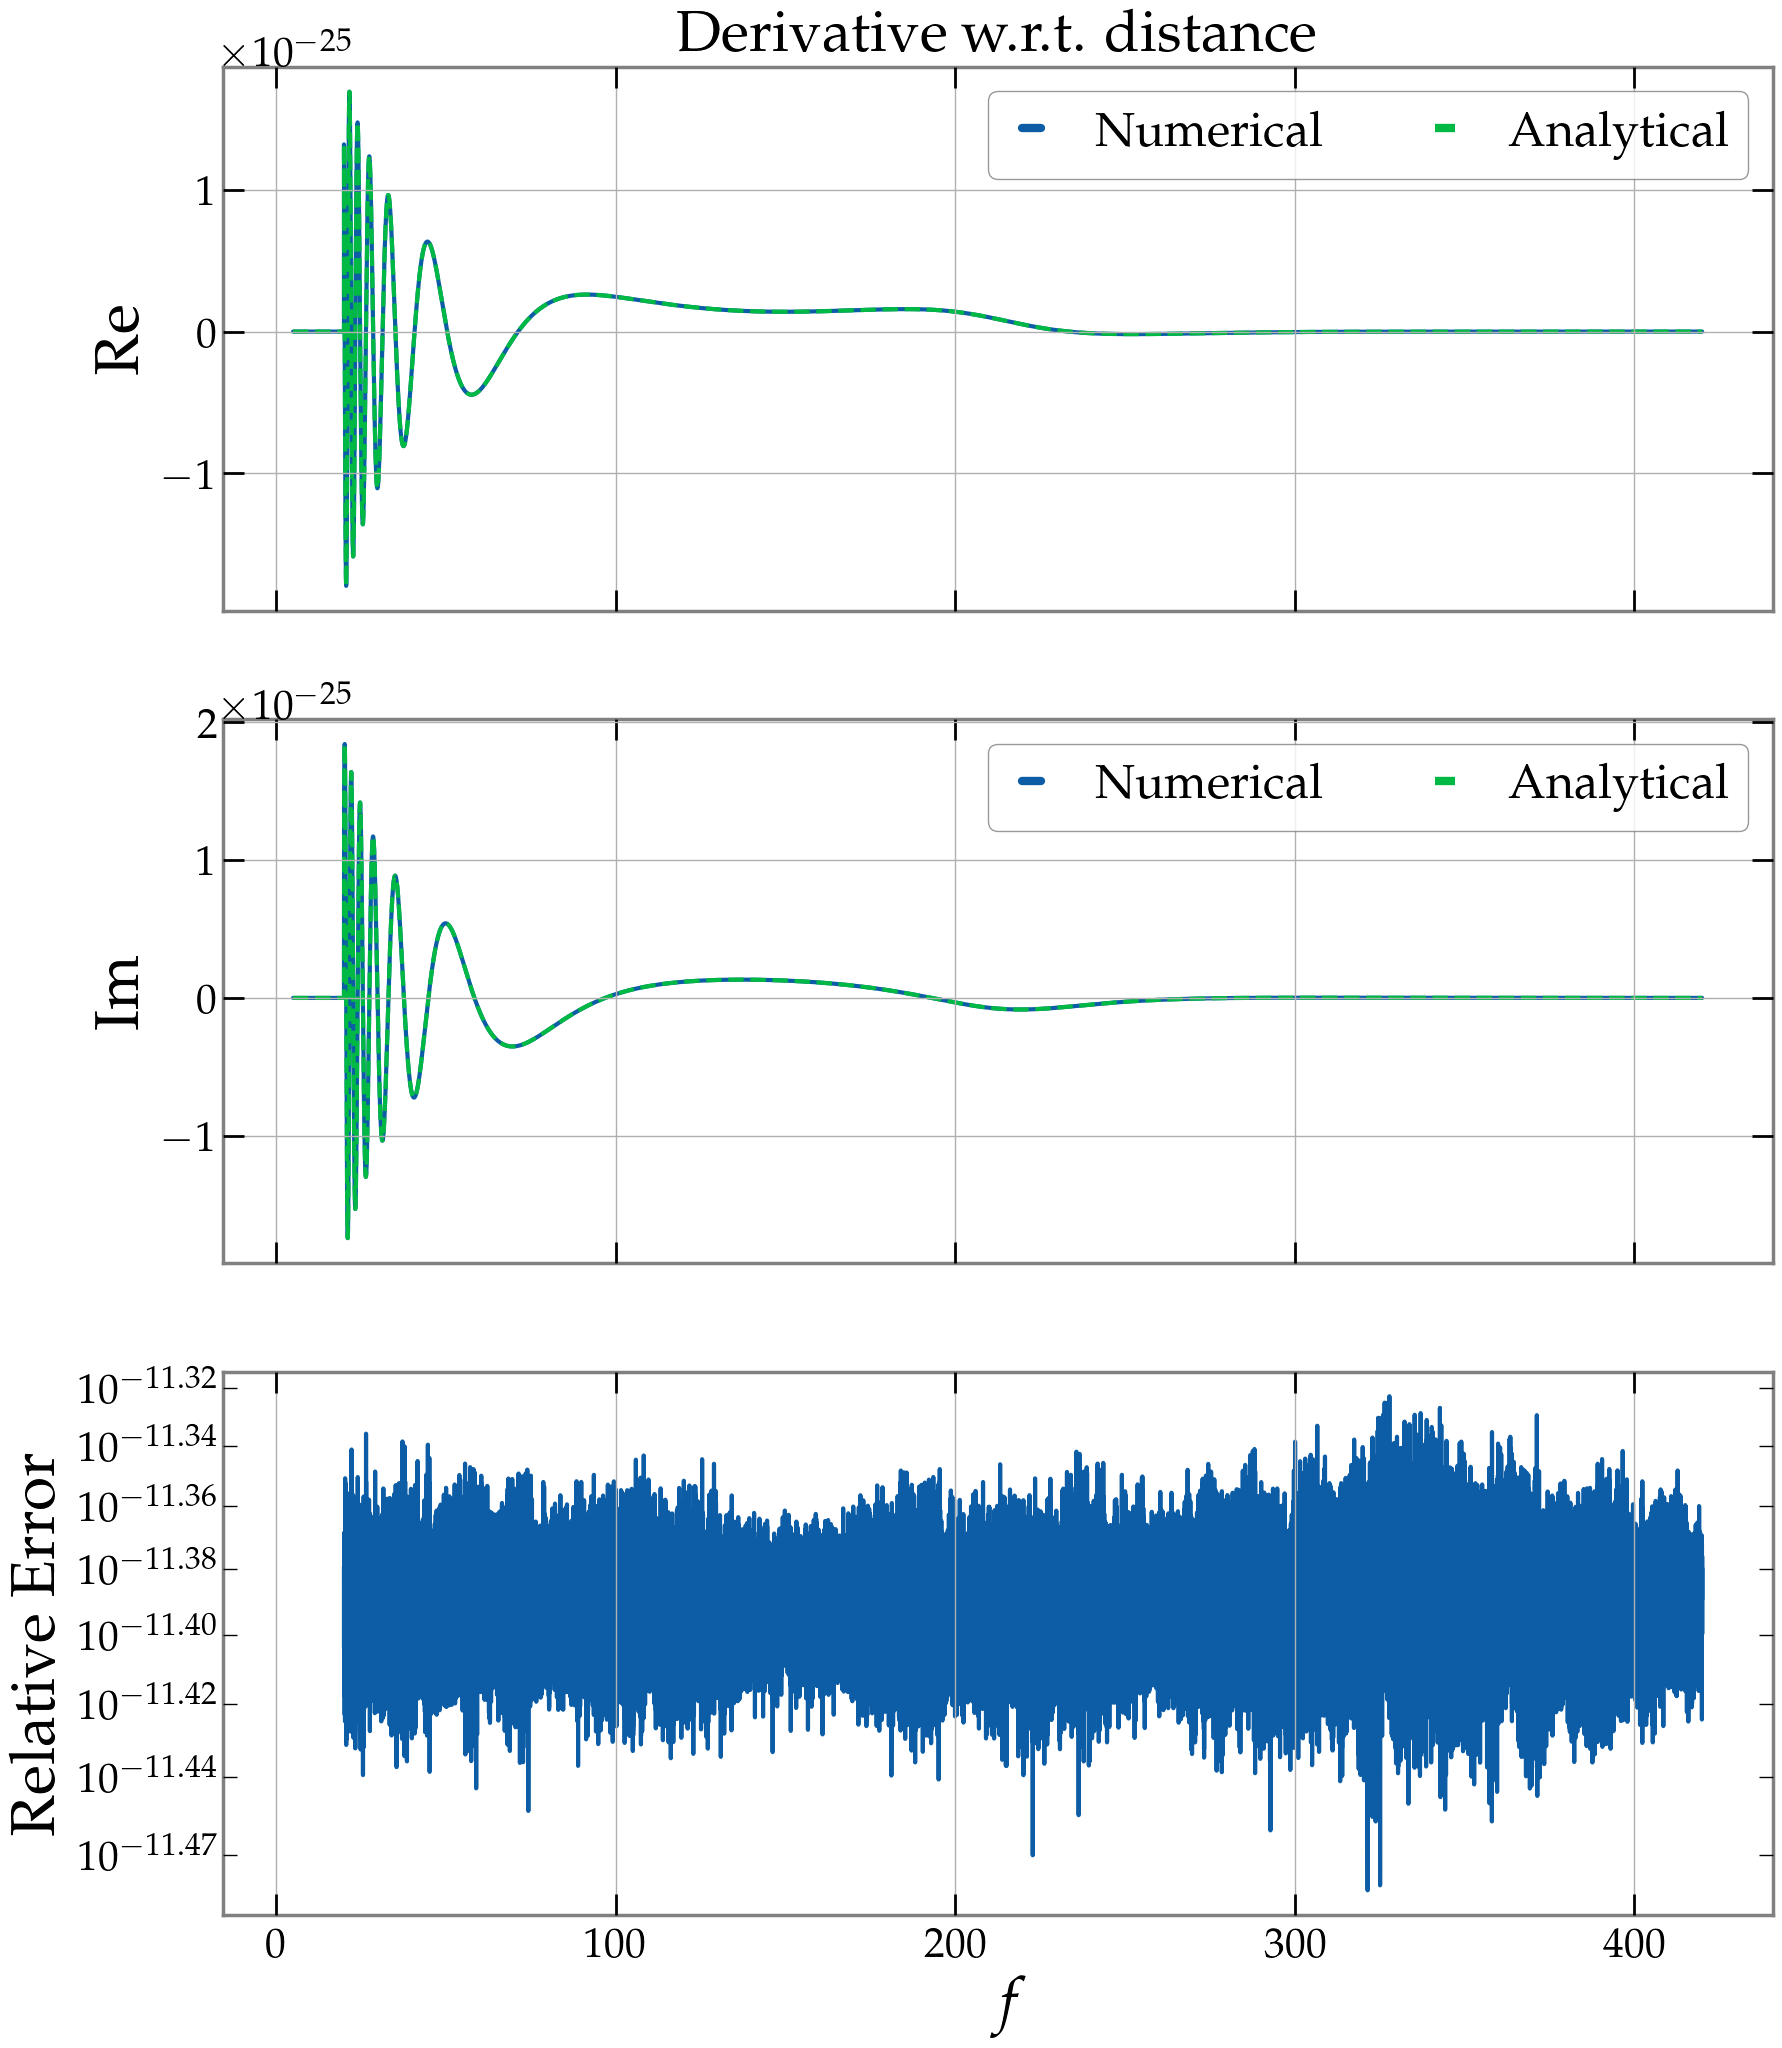

In [5]:
f_range=[5.*u.Hz, 420.*u.Hz]


fig, ax = plt.subplots(figsize=(20,24), nrows=3, sharex=True)

ax[0].plot(num_deriv_distance.crop(start=f_range[0], end=f_range[1]).real, label='Numerical')
ax[0].plot(ana_deriv_distance.crop(start=f_range[0], end=f_range[1]).real, '--', label='Analytical')


ax[1].plot(num_deriv_distance.crop(start=f_range[0], end=f_range[1]).imag, label='Numerical')
ax[1].plot(ana_deriv_distance.crop(start=f_range[0], end=f_range[1]).imag, '--', label='Analytical')


ax[2].plot(((ana_deriv_distance - num_deriv_distance) / ana_deriv_distance).abs().crop(start=f_range[0], end=f_range[1]))


ax[0].set_title('Derivative w.r.t. distance')
ax[0].legend(ncols=2)
ax[1].legend(ncols=2)
ax[2].set_yscale('log')
plt.xlabel('$f$')
ax[0].set_ylabel('Re')
ax[1].set_ylabel('Im')
ax[2].set_ylabel('Relative Error')
# plt.xlim(5, 100)

plt.show()

Very good agreement

## Benchmarking

In [1]:
import cProfile

In [21]:
cProfile.run(
    '''num_deriv, info_dict = get_waveform_derivative_1D_with_convergence(
    wf_params,
    param_to_vary,
    wf_generator,
    convergence_check='diff_norm',
    return_info=True
    )''',
    sort=1
)

plt.close()

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

         145622 function calls (144329 primitive calls) in 5.903 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       16    2.821    0.176    2.823    0.176 {built-in method lalsimulation._lalsimulation.SimInspiralGenerateFDWaveform}
      304    1.242    0.004    1.242    0.004 {built-in method lal._lal.DictInsertREAL8Value}
       32    0.242    0.008    0.373    0.012 array.py:319(epoch)
       16    0.195    0.012    5.415    0.338 waveform.py:334(generate_fd_waveform)
       32    0.139    0.004    0.139    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedFDApproximants}
       32    0.131    0.004    0.131    0.004 _tconvert.py:97(to_gps)
       32    0.130    0.004    0.130    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedTDApproximants}
       32    0.123    0.004    0.530    0.017 waveform.py:525(to_gwpy_Series)
      372    0.101    0.000    0.101    0.000 {me

Main contributor is waveform generation, which is expected and also fine (cannot be avoided).

In [10]:
from gw_signal_tools.waveform_utils import get_wf_generator
import astropy.units as u
import matplotlib.pyplot as plt

f_min = 20.*u.Hz
f_max = 1024.*u.Hz

wf_params = {
    'total_mass': 100.*u.solMass,
    'mass_ratio': 0.42*u.dimensionless_unscaled,
    'deltaT': 1./2048.*u.s,
    'f22_start': f_min,
    'f_max': f_max,
    'deltaF': 2**-5*u.Hz,
    'f22_ref': 20.*u.Hz,
    'phi_ref': 0.*u.rad,
    'distance': 1.*u.Mpc,
    'inclination': 0.0*u.rad,
    'eccentricity': 0.*u.dimensionless_unscaled,
    'longAscNodes': 0.*u.rad,
    'meanPerAno': 0.*u.rad,
    'condition': 0
}

test_params = ['total_mass', 'mass_ratio']


approximant = 'IMRPhenomXPHM'
wf_generator = get_wf_generator(approximant)#, mode='mixed')

# Make sure mass1 and mass2 are not in default_dict (makes messy behaviour)
import lalsimulation.gwsignal.core.parameter_conventions as pc
pc.default_dict.pop('mass1', None);
pc.default_dict.pop('mass2', None);

from gw_signal_tools.types.nd_deriv import WaveformDerivative

test_param = 'total_mass'
# test_param = 'mass_ratio'
# test_param = 'distance'
test = WaveformDerivative(
    wf_generator,
    wf_params,
    test_param,
    # base_step=1e-2
    # base_step=1e-2*wf_params[test_param].value,
    # method='forward'
)


from gw_signal_tools.types.deriv import Derivative
# print(Derivative.__dict__)
# print('five_point' in Derivative.__dict__)


test_deriv_object = Derivative(
    wf_params_at_point=wf_params,
    param_to_vary=test_param,
    wf_generator=wf_generator
)

test_deriv = test_deriv_object.deriv

from gw_signal_tools.fisher.fisher_utils import get_waveform_derivative_1D_numdifftools

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [11]:
cProfile.run(
    '''test_deriv = test_deriv_object.deriv''',
    sort=1
)

# plt.close()

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

         92399 function calls (91850 primitive calls) in 0.489 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       16    0.347    0.022    0.347    0.022 {built-in method lalsimulation._lalsimulation.SimInspiralGenerateFDWaveform}
      602    0.008    0.000    0.008    0.000 {function Quantity.__array_ufunc__ at 0x7fdf36bf5f80}
       83    0.007    0.000    0.011    0.000 {function Series.copy at 0x7fdf101dc4a0}
     7176    0.005    0.000    0.009    0.000 {built-in method builtins.getattr}
     1090    0.005    0.000    0.020    0.000 quantity.py:423(__new__)
      947    0.004    0.000    0.021    0.000 quantity.py:763(_new_view)
     2049    0.004    0.000    0.007    0.000 {built-in method numpy.array}
      602    0.004    0.000    0.034    0.000 quantity.py:612(__array_ufunc__)
     3137    0.004    0.000    0.007    0.000 quantity.py:573(__array_finalize__)
       16    0.004    0.000    0.007    0.000 utils.py

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [12]:
cProfile.run(
    '''test_deriv_2 = test.deriv''',
    sort=1
)

# plt.close()

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

         504495 function calls (503868 primitive calls) in 1.036 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       31    0.559    0.018    0.559    0.018 {built-in method lalsimulation._lalsimulation.SimInspiralGenerateFDWaveform}
        1    0.095    0.095    0.235    0.235 limits.py:143(_get_arg_min)
    32769    0.042    0.000    0.133    0.000 numeric.py:615(flatnonzero)
    32801    0.024    0.000    0.040    0.000 fromnumeric.py:1768(ravel)
        1    0.023    0.023    0.034    0.034 extrapolation.py:378(dea3)
    32770    0.015    0.000    0.033    0.000 fromnumeric.py:53(_wrapfunc)
        4    0.014    0.003    0.014    0.003 {built-in method scipy.ndimage._nd_image.correlate1d}
        2    0.013    0.007    0.013    0.007 {method 'partition' of 'numpy.ndarray' objects}
    32769    0.013    0.000    0.044    0.000 fromnumeric.py:1881(nonzero)
    32769    0.012    0.000    0.012    0.000 {method 'nonzero'

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [13]:
cProfile.run(
    '''test_deriv_3 = get_waveform_derivative_1D_numdifftools(
        wf_params_at_point=wf_params,
        param_to_vary=test_param,
        wf_generator=wf_generator,
    )''',
    sort=1
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

         995287 function calls (994126 primitive calls) in 1.973 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       61    1.107    0.018    1.107    0.018 {built-in method lalsimulation._lalsimulation.SimInspiralGenerateFDWaveform}
        2    0.187    0.093    0.458    0.229 limits.py:143(_get_arg_min)
    65538    0.082    0.000    0.260    0.000 numeric.py:615(flatnonzero)
    65602    0.048    0.000    0.078    0.000 fromnumeric.py:1768(ravel)
        2    0.029    0.015    0.042    0.021 extrapolation.py:378(dea3)
    65540    0.029    0.000    0.062    0.000 fromnumeric.py:53(_wrapfunc)
    65538    0.024    0.000    0.084    0.000 fromnumeric.py:1881(nonzero)
    65538    0.024    0.000    0.024    0.000 {method 'nonzero' of 'numpy.ndarray' objects}
        6    0.018    0.003    0.018    0.003 extrapolation.py:373(max_abs)
       31    0.017    0.001    0.019    0.001 function_base.py:1606(angle)
    80934    0